## Miller ECoG data of faces/houses (+ noise)

Includes CNN Model & few visuilizations

In [4]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [9]:
# All imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib import rcParams
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy import signal
#from nilearn import plotting
#from nimare import utils

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [10]:
#Data loading
alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here.
dat1 = alldat[1][0]
dat2 = alldat[1][1]

print(dat1.keys())
print(dat2.keys())


dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [11]:
Subj_0 = alldat[0][1]
Subj_3 = alldat[3][1] # subject 3 data > second session
Subj_4 = alldat[4][1]
Subj_5 = alldat[5][1] # subject 5 data > second session
Subj_6 = alldat[6][1]

In [12]:
#checking key_press for subject 5 the one we will work on for now
key_presses = Subj_3.get('key_press', [])
print(f"Recording {5}: {len(key_presses)} key presses")


Recording 5: 141 key presses


In [13]:
#Our Main Parameters of Subject 5
stim_id3 = Subj_3['stim_id']
t_on3 = Subj_3['t_on']
t_off3 = Subj_3['t_off']
key_press3 = Subj_3['key_press']
noise3 = Subj_3['stim_noise']
cat = Subj_3['stim_cat']

# Indexing
face_indicies = []
for i in range(len(cat)):
    if cat[i] == [2]:
        face_indicies += [i]
    else:
        pass
    
# Create variables just pertaining to face data
face_noise = noise3[face_indicies] # len = 315
face_t_on = t_on3[face_indicies] # len = 315
face_t_off = t_off3[face_indicies] # len = 315

In [14]:
# (From the main notebook) quick way to get broadband power in time-varying windows
V = Subj_3['V'].astype('float32')
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = V/V.mean(0)

In [15]:
# (From the main notebook) average the broadband power across all face stimuli and across all house stimuli
nt, nchan = V.shape
nstim = len(face_t_on)
trange = np.arange(-200, 400)
ts = face_t_on[:, np.newaxis] + trange

# shape is (315, 600, 60) - 315 trials (not sure why), 600 time interval, 60 electrodes (I'm not sure how this have 60 electrodes..)
V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))
V_face = V_epochs.mean(0)

In [16]:
electrodes = [42, 43, 44, 45, 46, 47]
X = V_epochs[:, 200:, electrodes]
y = np.ravel(key_press3)

X.shape, y.shape

((315, 400, 6), (141,))

Coding the actual CNN Starting here

In [17]:
# Mapping the key_press to the nearest time stamp, used t_on
# preparing labels
def prepare_labels(key_presses, total_samples):
    labels = np.zeros(total_samples, dtype=int)
    
    # Create a mapping of timestamps to indices
    t_on_idx_map = {t: idx for idx, t in enumerate(face_t_on)}
    
    for key_press in key_presses:
        # Find the closest timestamp index
        closest_idx = min(t_on_idx_map.keys(), key=lambda t: abs(t - key_press))
        if closest_idx in t_on_idx_map:
            labels[t_on_idx_map[closest_idx]] = 1
    
    return labels


total_samples = 315  # Example total_samples
y = prepare_labels(key_press3, total_samples)

# Ensure y matches the number of samples in X
if y.shape[0] > total_samples:
    y = y[:total_samples]
elif y.shape[0] < total_samples:
    y = np.pad(y, (0, total_samples - y.shape[0]), 'constant')

# Print shapes to ensure correctness
print("Shape of X:", (total_samples, 400, 6))  # Example shape of X
print("Shape of y:", y.shape)

# Verify the labels
print("Labels (y):", y)

Shape of X: (315, 400, 6)
Shape of y: (315,)
Labels (y): [0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1
 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0
 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0
 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1
 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0
 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0]


In [18]:
# define the CNN model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# cross-validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []
histories = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])
    loss, accuracy = model.evaluate(X_test, y_test)
    accuracies.append(accuracy)
    histories.append(history)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Since it's a binary classification, round the predictions to get binary values
    y_pred_binary = np.round(y_pred).astype(int)

    # Compute MAE
    mae = mean_absolute_error(y_test, y_pred_binary)
    mae_scores.append(mae)

# Calculate MSE
y_pred_prob = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_prob)

# results
print("Cross-Validation Accuracies:", accuracies)
print("Mean Accuracy:", np.mean(accuracies))
print("Mean Squared Error:", mse)
print("Mean Absolute Errors:", mae_scores)


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.5425 - loss: 0.7553 - val_accuracy: 0.6095 - val_loss: 1.1237
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6355 - loss: 0.7124 - val_accuracy: 0.5905 - val_loss: 0.6673
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5986 - loss: 0.7076 - val_accuracy: 0.5905 - val_loss: 0.7022
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6450 - loss: 0.6469 - val_accuracy: 0.5905 - val_loss: 0.7122
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6857 - loss: 0.6069 - val_accuracy: 0.6095 - val_loss: 0.7275
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7335 - loss: 0.5830 - val_accuracy: 0.6381 - val_loss: 0.6669
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7142 - loss: 0.5682 - val_accuracy: 0.6095 - val_loss: 0.7648
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7460 - loss: 0.5082 - val_accuracy: 0.5810 - val_loss: 0.6961

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5524 - loss: 0.8371 - val_accuracy: 0.5429 - val_loss: 0.6935
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6024 - loss: 0.6827 - val_accuracy: 0.6000 - val_loss: 0.6726
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5713 - loss: 0.7160 - val_accuracy: 0.6000 - val_loss: 0.6754
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6605 - loss: 0.6508 - val_accuracy: 0.5905 - val_loss: 0.6706
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6510 - loss: 0.6483 - val_accuracy: 0.5524 - val_loss: 0.6922
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6809 - loss: 0.6205 - val_accuracy: 0.5810 - val_loss: 0.6977
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6750 - loss: 0.5983 - val_accuracy: 0.5810 - val_loss: 0.6962
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6530 - loss: 0.5979 - val_accuracy: 0.5619 - val_loss: 0.7160

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5948 - loss: 0.7100 - val_accuracy: 0.5905 - val_loss: 0.6766
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5945 - loss: 0.6911 - val_accuracy: 0.5905 - val_loss: 0.7041
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6355 - loss: 0.6131 - val_accuracy: 0.5714 - val_loss: 0.7309
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6822 - loss: 0.6140 - val_accuracy: 0.5810 - val_loss: 0.6912
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6411 - loss: 0.6258 - val_accuracy: 0.6095 - val_loss: 0.7064
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6450 - loss: 0.5964 - val_accuracy: 0.5714 - val_loss: 0.7535
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6868 - loss: 0.5841 - val_accuracy: 0.5619 - val_loss: 0.7184
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7130 - loss: 0.5655 - val_accuracy: 0.5714 - val_loss: 0.7125


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BFC1310900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Cross-Validation Accuracies: [0.5142857432365417, 0.5523809790611267, 0.5523809790611267]
Mean Accuracy: 0.5396825671195984
Mean Squared Error: 0.2596539365907097
Mean Absolute Errors: [0.4857142857142857, 0.44761904761904764, 0.44761904761904764]


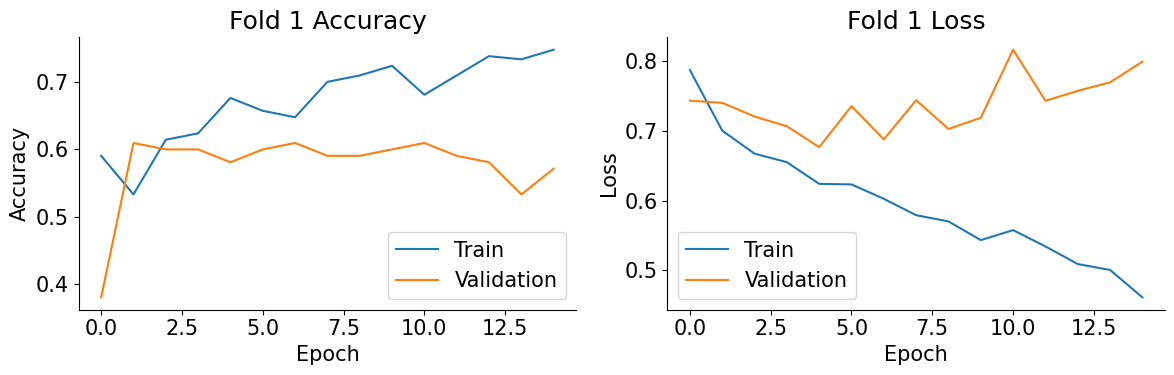

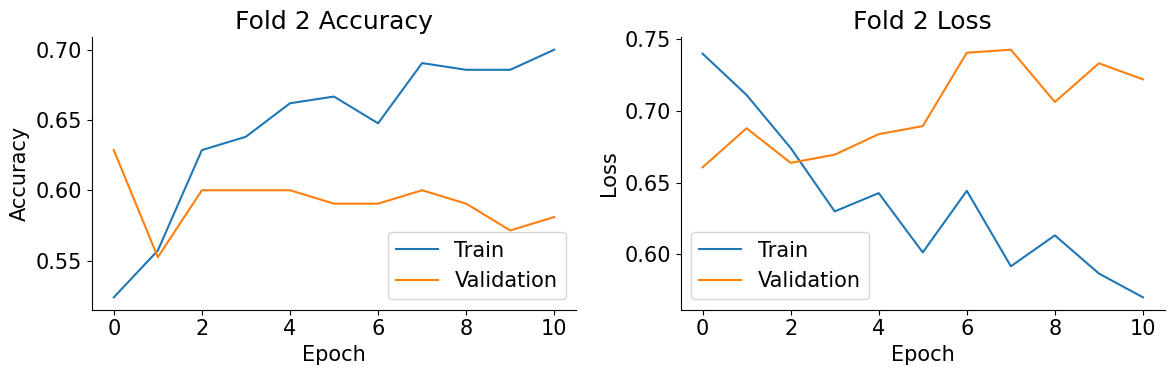

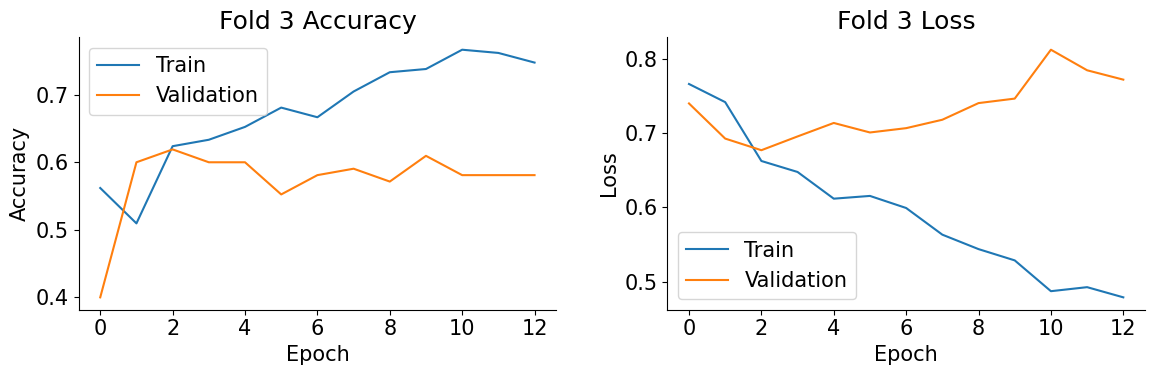

In [182]:
# training & validation accuracy and loss for each fold
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Fold {i+1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Fold {i+1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

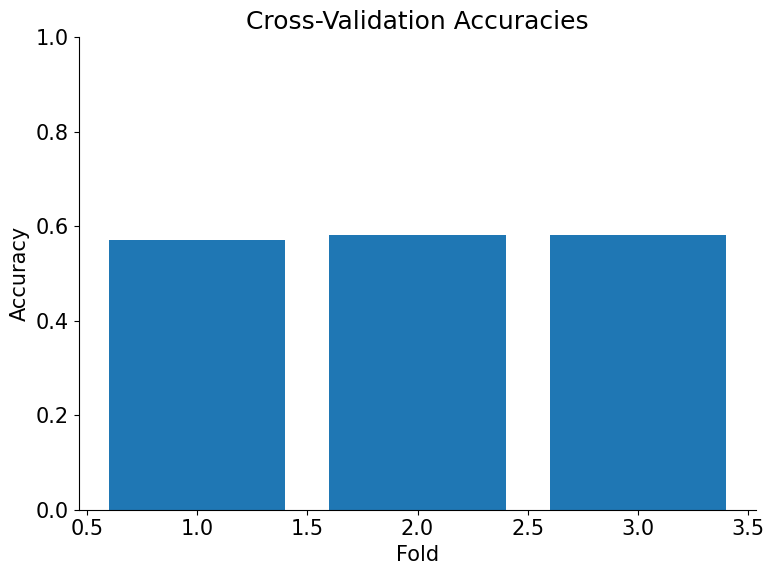

In [183]:
# cross-Validation Accuracy Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracies')
plt.ylim(0, 1)
plt.show()